In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

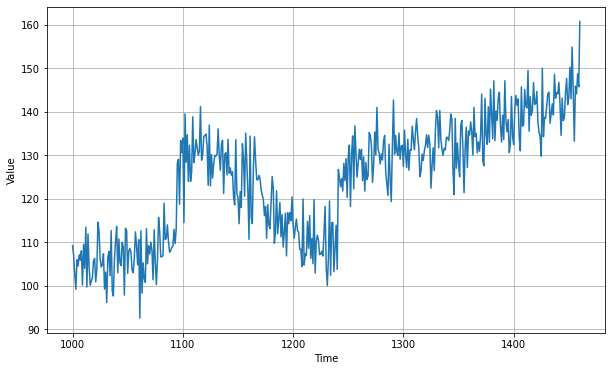

In [4]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)


Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 258.7312
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 49.3730
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 45.4770
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 43.9555
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 43.3559
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 42.4718
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 42.0957
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 41.8043
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 41.4059
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 41.1954
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 41.3825
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 40.5142
Epoch 13/100
31/31 [====

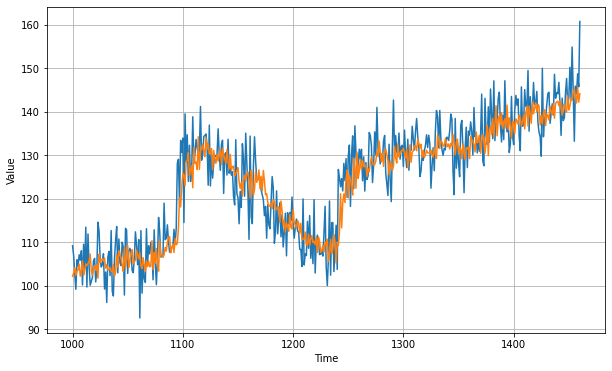

In [7]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.708754

In [18]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 80.3068
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 76.6344
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 74.4318
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 73.2750
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 72.8503
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 72.4878
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 72.2034
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 71.9412
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 71.6239
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 71.2641
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 70.8203
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 70.3658
Epoch 13/100
31/31 [=====

(1e-08, 0.001, 0.0, 300.0)

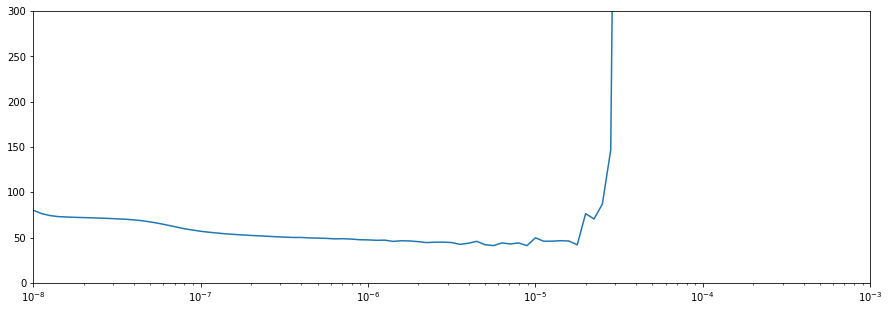

In [19]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize = (15, 5))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [20]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
31/31 [==============================] - 0s 2ms/step - loss: 3430.4231
Epoch 2/500
31/31 [==============================] - 0s 2ms/step - loss: 302.6372
Epoch 3/500
31/31 [==============================] - 0s 2ms/step - loss: 57.9048
Epoch 4/500
31/31 [==============================] - 0s 2ms/step - loss: 56.7254
Epoch 5/500
31/31 [==============================] - 0s 2ms/step - loss: 51.8933
Epoch 6/500
31/31 [==============================] - 0s 2ms/step - loss: 53.4132
Epoch 7/500
31/31 [==============================] - 0s 2ms/step - loss: 50.6646
Epoch 8/500
31/31 [==============================] - 0s 2ms/step - loss: 49.6943
Epoch 9/500
31/31 [==============================] - 0s 2ms/step - loss: 46.6815
Epoch 10/500
31/31 [==============================] - 0s 2ms/step - loss: 45.7089
Epoch 11/500
31/31 [==============================] - 0s 2ms/step - loss: 47.2827
Epoch 12/500
31/31 [==============================] - 0s 2ms/step - loss: 49.0497
Epoch 13/500
31/31 [==

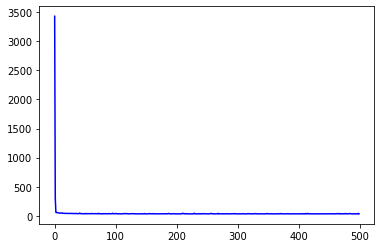

In [21]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[47.28273010253906, 49.04969787597656, 49.18122863769531, 43.03739547729492, 42.96656036376953, 42.52714538574219, 43.458282470703125, 41.11175537109375, 40.80772399902344, 41.418601989746094, 41.692474365234375, 43.72203063964844, 40.53213882446289, 39.603145599365234, 40.172035217285156, 41.10943603515625, 39.5982551574707, 40.86040496826172, 39.961734771728516, 38.186092376708984, 39.68938064575195, 38.6830940246582, 38.90702438354492, 38.682682037353516, 38.59430694580078, 40.73774337768555, 39.310054779052734, 39.25497817993164, 36.68689727783203, 36.69614791870117, 36.797386169433594, 46.47742462158203, 38.54132843017578, 36.517520904541016, 38.41924285888672, 35.80541229248047, 36.16535949707031, 36.24274826049805, 35.99746322631836, 36.36375427246094, 34.57184600830078, 40.66761016845703, 35.2574462890625, 36.041015625, 35.502288818359375, 36.11732864379883, 36.9808235168457, 35.899295806884766, 35.014129638671875, 34.558223724365234, 40.59709930419922, 37.43054962158203, 36.95

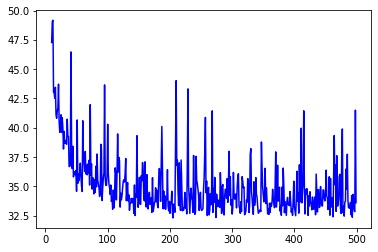

In [22]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

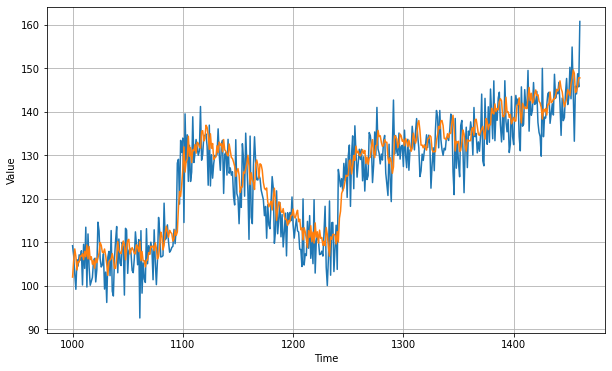

In [23]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [24]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7668266

--------